In [2]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, Dict, List, Tuple, Any, Optional
from statistics import mean
import numpy as np
from numpy.random import default_rng, Generator

In [3]:
# ========== 卷轴基础 ==========

@dataclass(frozen=True)
class Scroll:
    name: str
    success_p: float
    atk_gain: int
    destroy_on_fail_p: float = 0.0

SCROLL_A = Scroll("A_10p_+5", success_p=0.10, atk_gain=5, destroy_on_fail_p=0.0)
SCROLL_B = Scroll("B_60p_+2", success_p=0.60, atk_gain=2, destroy_on_fail_p=0.0)
SCROLL_C = Scroll("C_30p_+5_boom50", success_p=0.30, atk_gain=5, destroy_on_fail_p=0.50)
SCROLL_D = Scroll("D_70p_+2_boom50", success_p=0.70, atk_gain=2, destroy_on_fail_p=0.50)

SCROLL_SET = {"A": SCROLL_A, "B": SCROLL_B, "C": SCROLL_C, "D": SCROLL_D}
NAME_TO_KEY = {SCROLL_A.name: "A", SCROLL_B.name: "B", SCROLL_C.name: "C", SCROLL_D.name: "D"}  # 便于反查类型键

# ========== 状态与类型 ==========

@dataclass
class ItemState:
    attempts_used: int = 0               # 砸了几次卷轴
    successes: int = 0                   # 卷轴成功的次数
    total_atk: int = 0                   # 卷轴给装备增加的属性
    destroyed: bool = False              # 装备是否因卷轴消失
    history: List[str] = None            # 保存卷轴 display 名称
    result_history: List[bool] = None    # 整个砸卷过程的成功率

    def __post_init__(self):
        if self.history is None:
            self.history = []
        if self.result_history is None:
            self.result_history = []

@dataclass
class RunStats:
    total_items: int
    final_item_state: ItemState
    item_attacks_all: List[int]
    item_destroy_all: List[bool]
    total_scrolls_by_type: Dict[str, int]  # 本次试验总计的各类型卷轴消耗（跨多件）

Strategy = Callable[[ItemState, int, int], Scroll]
StopCondition = Callable[[ItemState], bool]

# ========== Monte Carlo ==========

def simulate_until_one_satisfy(
    rng: Generator,
    strategy: Strategy,
    upgrades: int, # 砸几次卷轴
    stop_condition: StopCondition,
) -> RunStats:

    total_items = 0
    destroy_list: List[bool] = []
    all_item_attacks: List[int] = []
    total_scrolls_by_type = {"A": 0, "B": 0, "C": 0, "D": 0}

    while True:
        state = ItemState()

        # 对每件装备的砸卷处理
        while state.attempts_used < upgrades:
            remaining = upgrades - state.attempts_used
            scroll = strategy(state, remaining, item_index=total_items)

            # 记录本次使用的卷轴
            state.history.append(scroll.name)
            # 按类型计数
            key = NAME_TO_KEY[scroll.name]
            total_scrolls_by_type[key] += 1

            # 消耗一次尝试
            state.attempts_used += 1

            # 判定
            if rng.random() < scroll.success_p:
                state.successes += 1
                state.total_atk += scroll.atk_gain
                state.result_history.append(True)
            else:
                state.result_history.append(False)
                # 判定该装备是否消失
                if scroll.destroy_on_fail_p > 0 and (rng.random() < scroll.destroy_on_fail_p):
                    state.destroyed = True
                    break

        # 累计全局统计
        total_items += 1
        destroy_list.append(state.destroyed)
        all_item_attacks.append(state.total_atk)

        if stop_condition(state):
            return RunStats(
                total_items=total_items,
                final_item_state=state,
                item_attacks_all=all_item_attacks,
                item_destroy_all=destroy_list,
                total_scrolls_by_type=total_scrolls_by_type,
            )

def monte_carlo_mix(
    rng: Generator,
    trials: int,
    strategy: Strategy,
    upgrades: int, # 砸几次卷
    stop_condition: StopCondition,
) -> Dict[str, Any]:
    
    total_scrolls_list: List[int] = []
    total_items_list: List[int] = []
    final_atk_list: List[int] = []
    final_successes_list: List[int] = []
    item_attacks_all: List[List[int]] = []
    item_destroy_all: List[List[bool]] = []

    # 每次试验的类型计数
    per_trial_scrolls_by_type: List[Dict[str, int]] = []
    for _ in range(trials):
        stats = simulate_until_one_satisfy(rng, strategy, upgrades, stop_condition)
        total_items_list.append(stats.total_items)
        final_atk_list.append(stats.final_item_state.total_atk)
        final_successes_list.append(stats.final_item_state.successes)
        item_attacks_all.append(stats.item_attacks_all)
        item_destroy_all.append(stats.item_destroy_all)
        per_trial_scrolls_by_type.append(stats.total_scrolls_by_type)

    return {
        # 原有分布（总卷轴/总装备）
        "items_distribution": total_items_list,
        # 新增：按类型的分布与均值
        "scrolls_distribution_by_type": per_trial_scrolls_by_type,  # 每种卷轴的消耗量
        "item_attacks_all": item_attacks_all, # 所有item的属性强化值
        "item_destroy_all": item_destroy_all, # 所有item的损坏状态
        "final_atk_list": final_atk_list, # 最终item的属性强化值
        "final_successes_list": final_successes_list, # 最终item成功的次数
    }

In [4]:
GROVE_ATTACK_PRICE = {
    10: [1500, 1488, 1499, 1488, 1488, 1450, 1450, 1455, 1399, 1350, 1499, 1288, 1499, 1338, 1335, 1234, 999, 1500],
    11: [2500, 2498, 2500, 2423, 2421, 2444, 2333, 2500],
    12: [5222, 5333, 5333, 5444, 5333, 5111, 5100, 5000, 5400, 5188, 5180, 5200, 5188, 5100, 5150, 5388, 5222, 5255, 5111],
    13: [13876, 15555, 15000, 15000, 14888, 14777, 14655, 14444, 14222, 11111],
    14: [40888, 41000, 40560]
    }
GROVE_SCROLL_PRICE = {"A": 33, "B": 597, "C": 14959, "D": 2325}


In [ ]:
def f(x, C, A, B):
    return C + A * np.exp(B * x)

In [ ]:
v_all = []
p_all = []
for v, p in GROVE_ATTACK_PRICE.items():
    for i in p:
        v_all.append(v)
        p_all.append(i)

atk_value = np.array(v_all, float)
price = np.array(p_all, float)


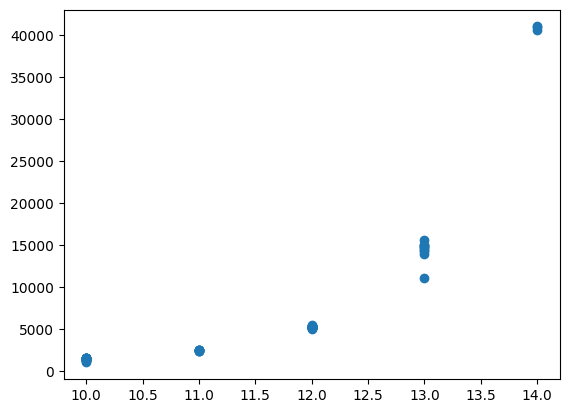

In [13]:
import matplotlib.pyplot as plt

plt.plot(v_all, p_all, "o")

Weber–Fechner fit:
  C = -77360028.2504 ± 4704554.5861
  A = 9871445.4667 ± 532354.0209
  x0 = -2521.9339 ± 136.6160
Pred atk 15: 19385 (95% CI [5156, 33613])
Pred atk 16: 23275 (95% CI [9458, 37093])
Pred atk 17: 27164 (95% CI [-1790, 56118])
Pred atk 18: 31051 (95% CI [18052, 44051])


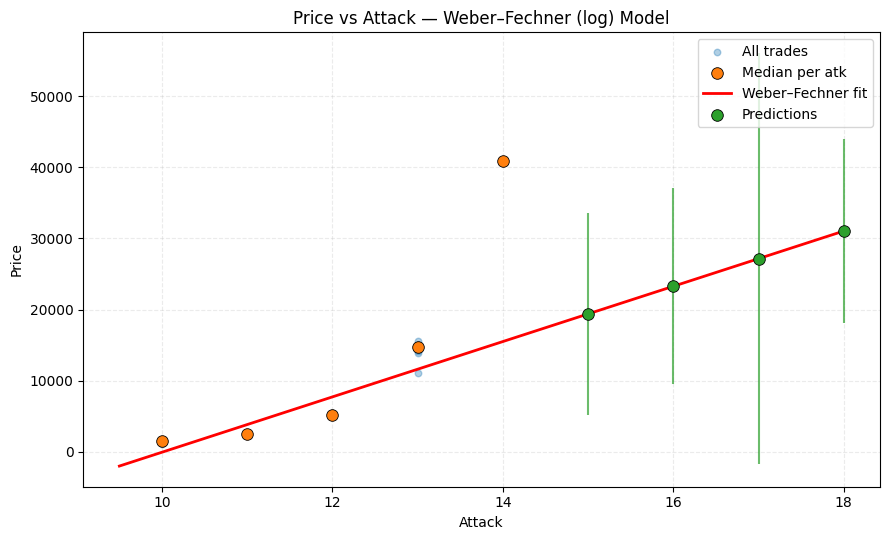

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# 原始数据
GROVE_ATTACK_PRICE = {
    10: [1500, 1488, 1499, 1488, 1488, 1450, 1450, 1455, 1399, 1350, 1499, 1288, 1499, 1338, 1335, 1234, 999, 1500],
    11: [2500, 2498, 2500, 2423, 2421, 2444, 2333, 2500],
    12: [5222, 5333, 5333, 5444, 5333, 5111, 5100, 5000, 5400, 5188, 5180, 5200, 5188, 5100, 5150, 5388, 5222, 5255, 5111],
    13: [13876, 15555, 15000, 15000, 14888, 14777, 14655, 14444, 14222, 11111],
    14: [40888, 41000, 40560]
}

# 展开所有散点（用于背景散点图）
xs_all, ys_all = [], []
for atk, prices in GROVE_ATTACK_PRICE.items():
    for p in prices:
        xs_all.append(atk)
        ys_all.append(p)
xs_all = np.array(xs_all, dtype=float)
ys_all = np.array(ys_all, dtype=float)

# 聚合为各攻击力的中位数，并构建稳健权重
xs, ys, ws = [], [], []
for atk, prices in GROVE_ATTACK_PRICE.items():
    p = np.array(prices, dtype=float)
    med = np.median(p)
    iqr = np.subtract(*np.percentile(p, [75, 25]))
    # 权重：样本数 / (1 + 相对四分位距)（抑制波动大的档位）
    w = len(p) / (1.0 + (iqr / (med + 1e-9)))
    xs.append(atk); ys.append(med); ws.append(w)

x = np.array(xs, dtype=float)
y = np.array(ys, dtype=float)
w = np.array(ws, dtype=float)

# 韦伯-费希纳模型：P(x) = C + A * log(x - x0)
def weber_fechner(x, C, A, x0):
    return C + A * np.log(np.maximum(x - x0, 1e-8))  # 数值稳定

# 初值选择
C0 = np.min(y) * 0.5               # 基线价格初猜
x0_0 = np.min(x) - 2.0             # 感知零点在最小x左侧
# 用线性近似估 A：y-C0 ≈ A * log(x - x0_0)
A0 = (np.max(y) - C0) / np.log(np.max(x) - x0_0)

# 加权拟合（absolute_sigma=True 使协方差有意义）
sigma = 1.0 / (w + 1e-9)  # sigma 越小权重越大
# 约束：x0 必须小于最小x，A>=0（价格随感知增加正相关），C 不限（也可设 >=0）
bounds = ([-np.inf, 0.0, -np.inf], [np.inf, np.inf, np.min(x) - 1e-3])

popt, pcov = curve_fit(
    weber_fechner, x, y,
    p0=[C0, A0, x0_0],
    sigma=sigma, absolute_sigma=True,
    bounds=bounds, maxfev=50000
)
C_hat, A_hat, x0_hat = popt
param_std = np.sqrt(np.diag(pcov))
print("Weber–Fechner fit:")
print(f"  C = {C_hat:.4f} ± {param_std[0]:.4f}")
print(f"  A = {A_hat:.4f} ± {param_std[1]:.4f}")
print(f"  x0 = {x0_hat:.4f} ± {param_std[2]:.4f}")

# 预测与置信区间（Delta method）
def predict_with_ci(x_new, popt, pcov, alpha=0.05):
    x_new = np.atleast_1d(x_new).astype(float)
    y_hat = weber_fechner(x_new, *popt)
    # 数值雅可比
    eps = 1e-6
    J = np.zeros((len(x_new), len(popt)))
    for j in range(len(popt)):
        dp = np.zeros_like(popt); dp[j] = eps
        y1 = weber_fechner(x_new, *(popt + dp))
        y0 = weber_fechner(x_new, *popt)
        J[:, j] = (y1 - y0) / eps
    var = np.einsum('ij,jk,ik->i', J, pcov, J)
    se = np.sqrt(np.maximum(var, 0))
    z = norm.ppf(1 - alpha/2)
    lo = y_hat - z * se
    hi = y_hat + z * se
    return y_hat, lo, hi

# 绘制拟合曲线
x_grid = np.linspace(9.5, 18, 500)
y_fit = weber_fechner(x_grid, *popt)

# 外推点与区间
x_future = np.array([15, 16, 17, 18], dtype=float)
y_pred, y_lo, y_hi = predict_with_ci(x_future, popt, pcov, alpha=0.05)
for xi, yp, lo, hi in zip(x_future, y_pred, y_lo, y_hi):
    print(f"Pred atk {xi:.0f}: {yp:.0f} (95% CI [{lo:.0f}, {hi:.0f}])")

# 作图
plt.figure(figsize=(9, 5.5))

# 背景所有成交散点
plt.scatter(xs_all, ys_all, s=22, alpha=0.35, label='All trades', color='#1f77b4')

# 各档位中位数点
plt.scatter(x, y, s=70, label='Median per atk', color='#ff7f0e', zorder=3, edgecolor='k', linewidth=0.6)

# 拟合曲线
plt.plot(x_grid, y_fit, 'r-', lw=2.0, label='Weber–Fechner fit')

# 未来预测点与区间
plt.scatter(x_future, y_pred, color='#2ca02c', s=70, label='Predictions', zorder=3, edgecolor='k', linewidth=0.6)
for xi, yp, lo, hi in zip(x_future, y_pred, y_lo, y_hi):
    plt.vlines(xi, lo, hi, color='#2ca02c', linestyles='-', alpha=0.7)

# 轴与图例
plt.xlabel('Attack')
plt.ylabel('Price')
plt.title('Price vs Attack — Weber–Fechner (log) Model')
# 在对数模型下，y 不一定要设对数轴；如需对比其他模型可尝试 plt.yscale('log')
plt.grid(True, ls='--', alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()